Imports

In [60]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
import time

In [61]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Initial Preprocessing

In [62]:
from pandas import read_csv
data = pd.read_csv('../data/UCI_2010_2014.csv')
data = data.drop('No', axis=1, inplace=False)

In [4]:
data = data.drop(['year','month','day','hour'], axis=1, inplace=False)

In [5]:
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In [6]:
# mark all NA values with 0
data['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
data = data[24:]
# summarize first 5 rows
print(data.head(5))
# save to file
#data.to_csv('pollution.csv')

    pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
24      129.0  -16  -4.0  1020.0      SE     1.79     0     0
25      148.0  -15  -4.0  1020.0      SE     2.68     0     0
26      159.0  -11  -5.0  1021.0      SE     3.57     0     0
27      181.0   -7  -5.0  1022.0      SE     5.36     1     0
28      138.0   -7  -5.0  1022.0      SE     6.25     2     0


## Baseline LSTM + room to change network architecture

In [65]:
dataset = pd.read_csv('../data/merged_final_UCI_format.csv', index_col=0)

In [68]:
# load dataset
dataset = pd.read_csv('../data/pollution.csv', header=0, index_col=0)
#dataset = pd.read_csv('../data/merged_final_UCI_format.csv', index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# frame as supervised learning -
####### Can change t_input timesteps here ##########  ### I changed it to time lag = 4
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
#values = scaled
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaled_features = scaler.fit_transform(values[:,:-1])
scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
values = np.column_stack((scaled_features, scaled_label))

n_train_hours = 365 * 24 + (365 * 48)
train = values[:n_train_hours, :]
test = values[n_train_hours:-365*24, :]
# split into input and outputs
# features take all values except the var1
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      129.0      -16.0       -4.0     1020.0        2.0       1.79   
2      148.0      -15.0       -4.0     1020.0        2.0       2.68   
3      159.0      -11.0       -5.0     1021.0        2.0       3.57   
4      181.0       -7.0       -5.0     1022.0        2.0       5.36   
5      138.0       -7.0       -5.0     1022.0        2.0       6.25   

   var7(t-1)  var8(t-1)  var1(t)  
1        0.0        0.0    148.0  
2        0.0        0.0    159.0  
3        0.0        0.0    181.0  
4        1.0        0.0    138.0  
5        2.0        0.0    109.0  


### Nonlinear Regression Analysis

#### Fit to train set and predict on train, calculate errors

In [41]:
from sklearn.svm import SVR

x = train_X
y = train_y

regr = SVR(C = 2.0, epsilon = 0.1, kernel = 'rbf', gamma = 0.5, 
           tol = 0.001, verbose=False, shrinking=True, max_iter = 10000)

regr.fit(x, y)
data_pred = regr.predict(x)
y_pred = scaler.inverse_transform(data_pred.reshape(-1,1))
y_inv = scaler.inverse_transform(y.reshape(-1,1))

mse = mean_squared_error(y_inv, y_pred)
rmse = np.sqrt(mse)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

print('Variance score: {:2f}'.format(r2_score(y_inv, y_pred)))


Mean Squared Error: 2033.0185
Root Mean Squared Error: 45.0890
Variance score: 0.746847


#### Plot Function

In [69]:
def plot_preds_actual(preds, actual):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.plot(preds, color='red', label='Predicted data')
    ax.plot(actual, color='green', label='True data')
    ax.set_xlabel('Hourly Timestep in First Month of Predicted Year', fontsize=16)
    ax.set_ylabel('Pollution [pm2.5]', fontsize=16)
    ax.set_title('Nonlinear Regression using SVR on Test set', fontsize=16)
    ax.legend()
    plt.show()

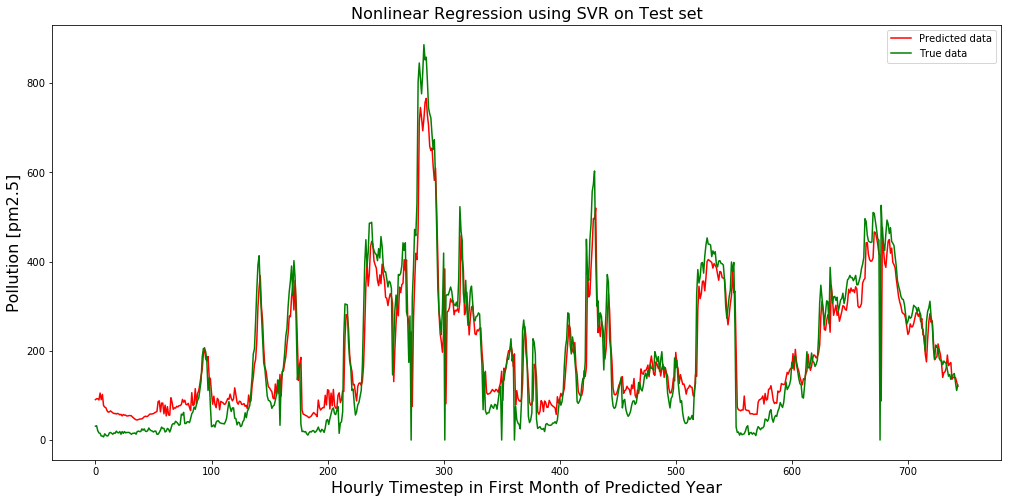

In [70]:
plot_preds_actual(y_pred[:24*31*1,], y_inv[:24*31*1,])

#### Predict on test/dev sets and Calculate errors

In [35]:
def run_test_nonlinear_reg(x, y):
    data_pred = regr.predict(x)
    y_pred = scaler.inverse_transform(data_pred.reshape(-1,1))
    y_inv = scaler.inverse_transform(y.reshape(-1,1))

    mse = mean_squared_error(y_inv, y_pred)
    rmse = np.sqrt(mse)
    print('Mean Squared Error: {:.4f}'.format(mse))
    print('Root Mean Squared Error: {:.4f}'.format(rmse))

    #Calculate R^2 (regression score function)
    #print('Variance score: %.2f' % r2_score(y, data_pred))
    print('Variance score: {:2f}'.format(r2_score(y_inv, y_pred)))
    return y_pred, y_inv

In [58]:
y_pred, y_inv = run_test_nonlinear_reg(test_X, test_y)

Mean Squared Error: 1938.9279
Root Mean Squared Error: 44.0333
Variance score: 0.798516


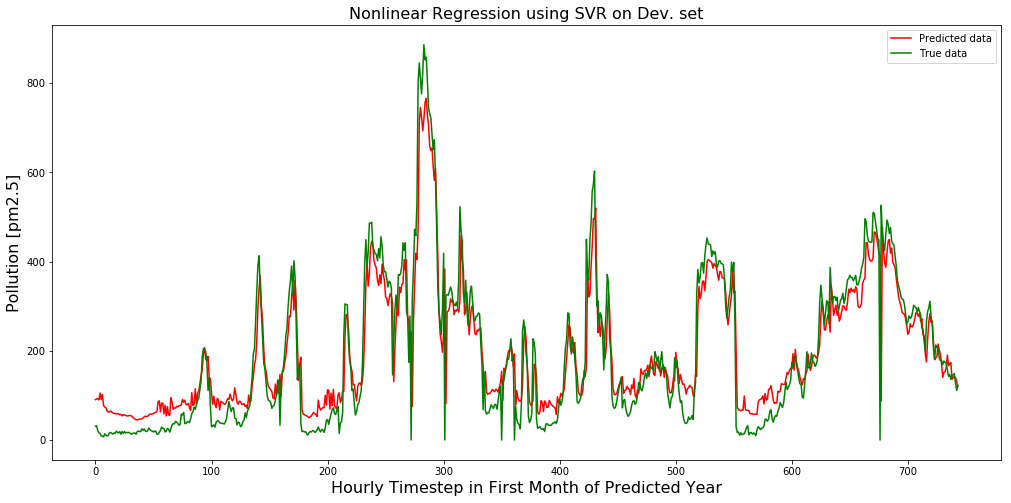

In [59]:
plot_preds_actual(y_pred[:24*31*1,], y_inv[:24*31*1,])

### KNN Time Series

In [9]:
import tslearn

In [10]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

### SVM

In [47]:
from sklearn import svm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

In [43]:
clf = svm.SVR(kernel='rbf')
clf.fit(train_X2d, train_y)
test_preds = clf.predict(test_X2d)

In [48]:
mse = mean_squared_error(test_y, test_preds)

In [49]:
rmse = np.sqrt(mse)

In [50]:
rmse

0.035110434547262037

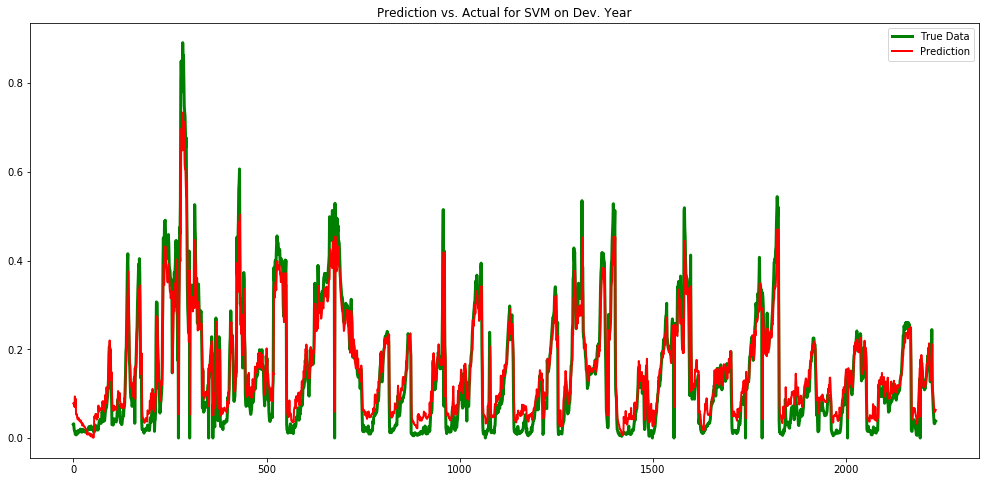

In [53]:
plot_preds_actual(test_preds[:24*31*3,], test_y[:24*31*3,])

In [51]:
start = time.time()
# make a prediction
yhat = clf.predict(test_X2d)
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X = test_X2d#test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
end = time.time()
print('This took {} seconds.'.format(end - start))
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

IndexError: axis 1 out of bounds [0, 1)

In [27]:
clf = KNeighborsTimeSeriesClassifier(n_neighbors=4, metric='dtw')

In [22]:
dim1x, dim3x = train_X.shape[0], train_X.shape[2]

In [23]:
train_X2d = train_X.reshape(dim1x, dim3x)

In [25]:
train_X2d.shape

(26280, 8)

In [26]:
train_y.shape

(26280,)

In [28]:
clf.fit(train_X2d, train_y)

In [29]:
#train_X.reshape(26280,8)

In [30]:
#train_X.shape

In [33]:
dim1x_test, dim3x_test = test_X.shape[0], test_X.shape[2]

In [34]:
test_X2d = test_X.reshape(dim1x_test, dim3x_test)

In [31]:
#train_preds = clf.predict([1,2,3,4,5,6,3,5])

In [39]:
#test_preds = clf.predict(test_X2d)

In [ ]:
#test_preds = clf.predict(test_X)

In [52]:
def plot_preds_actual(preds, actual):
    ''' Plot predicted vs. actual '''
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual for SVM on Dev. Year')
    ax.plot(actual, label='True Data', color='green', linewidth='3')
    ax.plot(preds, label='Prediction', color='red', linewidth='2')
    plt.legend()
    plt.show()

Train on 26280 samples, validate on 17519 samples
Epoch 1/2
26280/26280 [==============================] - 3s 112us/step - loss: 0.0262 - val_loss: 0.0148
Epoch 2/2
26280/26280 [==============================] - 2s 86us/step - loss: 0.0148 - val_loss: 0.0136


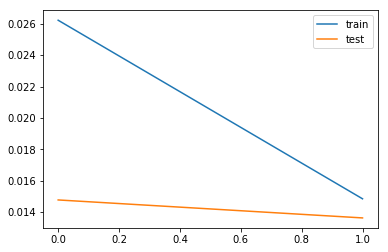

This took 6.8797290325164795 seconds.
Test RMSE: 27.037


In [18]:
start = time.time()

# fit network
###################### Can change Epochs, Batch size here #######################
history = model.fit(train_X, train_y, epochs=2, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
end = time.time()
print('This took {} seconds.'.format(end - start))
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)